In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

### 한글 깨짐 설정
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if( platform.system() =='Darwin' ):
    rc( 'font', family='AppleGothic' )
elif( platform.system() == 'Windows'):
    path='c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties( fname=path ).get_name()
    rc('font',family=font_name)
else:
    print('error')

### 앙상블 학습과 랜덤 포레스트

- 앙상블 학습 : 일련의 예측기를 이용한 학습
    - 결정 트리의 앙상블 : 랜덤 포레스트
    
### 7.1 투표 기반 분류기

- 각 모델의 예측값을 가지고 **다수결 투표**를 통해 최종 클래스를 예측하는 방법
- 다수결 투표로 정해지는 분류기를 **직접 투표** 분류기라고 한다.
- 투표 기반 분류기 주의 점
    - 모든 분류기가 독립적이어야 하고, 오차에 대해 상관관계가 없어야 한다. 
    - 앙상블 기법에서 독립적인 모델을 만들어 주기 위해서는 다른 머신러닝 알고리즘으로 학습시키는 것이 좋다. 
    - 그 이유는 모델 별로 다른 종류의 오차를 가지므로 상관관계가 작어지기 때문이다.

**Hard voting**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
# voting_clf.fit(X_train, y_train)

In [13]:
# LabelEncoder 버그로 인해 생기는 DeprecationWarning 막기
# https://github.com/scikit-learn/scikit-learn/pull/9816
# https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


**Soft voting**

- 각 분류기의 예측값(레이블)의 확률을 가지고 평균을 구한 뒤, 평균이 가장 높은 클래스로 최종 앙상블 예측이 이루어진다. 이러한 방법을 **간접 투표**(soft voting)

In [15]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42) # svc 확률 제공을 위해 probability = True

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
# voting_clf.fit(X_train, y_train)

In [16]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


### 7.2 배깅과 페이스팅

- 학습 데이터셋에서 랜덤하게 추출할 때, 중복을 허용하는 방식을 **배깅**
    - 배깅(bagging)은 **bootstrap aggregating**의 줄임말이며 통계학에서는 중복을 허용한 리샘플링(resampling)을 **부트스트래핑**
- 중복을 허용하지 않는 샘플링 방식을 **페이스팅**

##### 7.2.1 사이킷런의 배깅과 페이스팅

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
from sklearn.tree import DecisionTreeClassifier

# 단일 결정 트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 500개의 결정 트리
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


배깅을 이용한 방법이 정확도가 5%나 더 좋게 나온것을 확인할 수 있다

In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

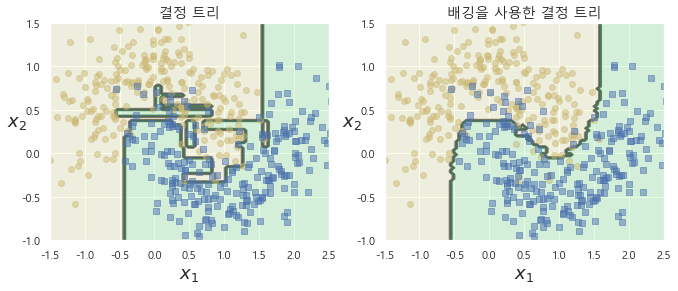

In [21]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

##### 7.2.2 OOB(Out-of-Bag) 평가

- **oob(out-of-bag) 샘플** : 평균적으로 학습 단계에서 전체 학습 데이터셋 중 63% 정도만 샘플링 되며, 샘플링 되지 않은 나머지 37% 데이터 샘플

In [22]:
# oob_score = True : oob 샘플을 사용해 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

print('oob score :', bag_clf.oob_score_)

oob score : 0.9013333333333333


In [23]:
# 실제 평가
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [24]:
# oob 샘플에 대한 결정함수 값 확인 가능
bag_clf.oob_decision_function_[:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

### 7.3 Random Patches & Random Subspace

`BaggingClassifier`는 특성(feature) 샘플링 또한 `max_features`와 `bootstrap_features` 두 개의 인자를 통해 제공한다. 위의 두 인자를 이용해 각 모델은 랜덤하게 선택한 특성(feature)으로 학습하게 된다.

이러한 방법은 데이터의 특성이 많은 고차원의 데이터셋을 다룰 때 적절하다. 학습 데이터 셋의 특성 및 샘플링(bootstraping) 사용 유무에 따라 두 종류로 나눌 수 있다.

- **Random Patches method** : 특성 및 데이터 셋 샘플링(bootstraping) 모두 사용하는 방식 
- **Random Subspace method** : 특성만 샘플링하는 방식
    - `bootstrap=False` 이고, `bootstrap_features=True` 그리고 `max_features`는 1.0보다 작은 값

이러한 특성 샘플링은 더 다양한 모델을 만들며 편향은 늘어나지만 분산을 낮출 수 있다.

### 7.4 랜덤 포레스트

##### 7.4.1 엑스트라 트리

